------

LEFTOVERS:   


    1) Tensor board graphs for loss    
    2) Tensor board for network vis   
    3) Is embedding good or not ?
    4) Embedding visualization ?
    5) model perplexity
    
------

In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os.path

In [3]:
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='Untitled3_1_LOG.txt', mode='a')
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

## Data conversation utils

In [4]:
data_file = '../data/harry_potter_3.txt'

fp = open(data_file, 'r')
data = fp.read()

print (type(data))

print (data[:200])

<class 'str'>
Harry Potter and the Prisoner of Azkaban

by J.K. Rowling

CHAPTER ONE

OWL POST

Harry Potter was a highly unusual boy in many ways. For one thing, he
hated the summer holidays more than any other ti


In [5]:
#get the character set of data
chars = list(set(data))
vocab_size = len(chars)

print (len(chars), chars)

79 ['k', 'N', 'G', 'o', ' ', '\n', 'R', 'j', '\\', '_', 'a', ')', '4', 'F', '7', 'P', 'u', 'f', '(', ';', ',', 'q', 'K', 'n', '5', 'L', '0', 'O', 'J', 'V', 'c', 'D', 'U', '1', '6', '.', '3', '`', 'H', '-', 'X', '*', 'l', 'w', 'v', 't', 'T', 'p', 'r', '9', 'B', 'x', 'y', ':', 'h', '?', 'A', 'I', 'C', 's', '"', "'", 'b', '!', '2', '&', 'Z', 'g', 'W', 'e', 'M', 'd', 'Q', 'm', 'i', 'z', 'Y', 'S', 'E']


In [6]:
data_size, char_set_size = len(data), len(chars)
print ('data has %d characters, %d unique.' % (data_size, char_set_size))


data has 611606 characters, 79 unique.


In [7]:
char_to_ix = {ch:i for i,ch in enumerate(chars)}

In [8]:
ix_to_char = {i:ch for i,ch in enumerate(chars)}

In [9]:
input = 'ABCDabcd'
map(lambda ch: char_to_ix[ch], input)  

In [10]:
def c2i(input):
    return map(lambda ch: char_to_ix[ch], input)  

In [11]:
def i2c(input):
    return map(lambda ch: ix_to_char[ch], input)  

--------- 

## Prepare Training data
--------- 

raw_data = 'abcdefghijklmonpqrstuvwxyzABCDEGHIJKLMONPQRSTUVWXYZ123456789!@#$%^&*()'

data_len = len(raw_data)
print data_len

seq_length = 3 # number of steps to unroll the RNN for
batch_size = 6

num_examples = (data_len - 1) // seq_length
print num_examples

num_batches = num_examples // batch_size
print num_batches

for i in range(num_batches):
    print "i = %d" %i
    idx = i * batch_size * seq_length
    print "idx = %d" %idx
    
    for j in range(batch_size):
        start_index = idx + (j*seq_length)
        end_index = idx + (j+1)*seq_length
        print "start_index = %d, end_index = %d" %(start_index, end_index)

raw_data.upper()

In [12]:
# Generate data for an epoch, with batches of size batch_size.

def gen_epoch_data(raw_data, batch_size, seq_length=25):
    
    data_len = len(raw_data)
    
    # num_examples is num_of_sequences. each sequence is an example
    num_examples = (data_len - 1) // seq_length
    
    num_batches = num_examples // batch_size 
    
    # intuituion for the abovce 2 lines is - we are to feed sequences. If each seq is of length k and there are N 
    # sequences in each batch - then a batch basically consists of k*N characters; 
    # thus number of batches = data_len // (seq_lenth * batch_size)
    
    # An easier way to see this is : num of data points = data_len // seq_length
    # therefore num of batches = num of data points // batch_size
    
    # to get training data, we iterate over batches/chunks/rows. First we establish from where the batch data starts 
    # imagine data to be a a st line ------------- of length data_len
    # we split it into batches 
    #    ----------------
    #    ----------------
    #    ----------------
    
    # These (^) text split into chunks/rows - num_of_chunks =  data_len // (seq_lenth * batch_size)
    # first get which chuck to pick. This is done by idx = i * batch_size * seq_length
    
    # once u have the right row - each point in batch is a seq,seq, we need to pick num_of_piars = batch_size
    # so iterate over batch_size
    # starting point in a chunk is jth sequence * length of 1 seq
    
    epoch_data = []
    
    for i in range(num_batches):
        batch = []
        idx = i * batch_size * seq_length
        
        for j in range(batch_size):
            start_index = idx + (j*seq_length)
            end_index = idx + (j+1)*seq_length
            input_ = raw_data[start_index : end_index]
            target_ = raw_data[start_index + 1 : end_index +1 ]
            
            batch.append([c2i(input_), c2i(target_)])
            
        epoch_data.append(batch)
        
    return epoch_data

# Test Data Generation 

In [13]:
check_data = gen_epoch_data(raw_data=data, batch_size=32)

In [14]:
print (type(check_data), len(check_data))
print (len(check_data[0]))
print (check_data[0]) # this is a list of lists of lists

<class 'list'> 764
32
[[<map object at 0x7fa8b32162e8>, <map object at 0x7fa8b3216400>], [<map object at 0x7fa8b32164e0>, <map object at 0x7fa8b32165f8>], [<map object at 0x7fa8b3216550>, <map object at 0x7fa8b32166a0>], [<map object at 0x7fa8b32166d8>, <map object at 0x7fa8b32167f0>], [<map object at 0x7fa8b3216828>, <map object at 0x7fa8b3216908>], [<map object at 0x7fa8b3216940>, <map object at 0x7fa8b3216978>], [<map object at 0x7fa8b3216a20>, <map object at 0x7fa8b3216b38>], [<map object at 0x7fa8b3216c18>, <map object at 0x7fa8b3216c50>], [<map object at 0x7fa8b3216b70>, <map object at 0x7fa8b3216d30>], [<map object at 0x7fa8b3216e80>, <map object at 0x7fa8b3216e48>], [<map object at 0x7fa8b3216d68>, <map object at 0x7fa8b3216eb8>], [<map object at 0x7fa8b3216f98>, <map object at 0x7fa8b3216f60>], [<map object at 0x7fa8b3216a90>, <map object at 0x7fa8b3216ac8>], [<map object at 0x7fa8b32167b8>, <map object at 0x7fa8ca95dc50>], [<map object at 0x7fa8b321f048>, <map object at 0x7fa

# Set Params

In [15]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 2e-1
batch_size = 50


#num_epochs = 500
num_epochs = 1

# Build the Network

In [16]:
import tensorflow as tf

# Input
x = tf.placeholder(tf.int32, shape=(seq_length), name="x")
y = tf.placeholder(tf.int32, shape=(seq_length), name="y")


In [17]:
# One Hot representation of the input
x_oh = tf.one_hot(indices=x, depth=vocab_size)
y_oh = tf.one_hot(indices=y, depth=vocab_size)

In [18]:
#check and balances 

print (x.get_shape())
print (y.get_shape())

print (x_oh.get_shape())
print (y_oh.get_shape())

(25,)
(25,)
(25, 79)
(25, 79)


In [19]:
# input and output as of now is 25 characters, each in 1-hot format of length 80
# we will need to feed it 1 character (in 1-hot format) at a time   

#We will convert it into desired format in 2 steps - from (25,80) to 25 tensors of
#shape (80,) then to 25 tensors of shape (1,80)

# Convert the VxN tensor into list of V tensors each of shape = (V,).
rnn_inputs = tf.unstack(value=x_oh)
rnn_targets = tf.unstack(value=y_oh)

#Unpacks the given dimension of a rank=R tensor into rank=(R-1) tensors
#i'th tensor in output is the slice value[i, :]. 
# given a tensor of shape (A, B, C, D);
#If axis == 0 (default value) then the i'th tensor in output is the slice value[i, :, :, :] 
#and return a list of tensors, where each tensor in output will have shape (B, C, D)

# for our data, rank of x_oh is 2 and shape = (25,80)
#rank is number of dimensions


In [20]:
rnn_inputs[0].get_shape()

TensorShape([Dimension(79)])

In [21]:
# Setup the weights and biases.
with tf.variable_scope('rnn_cell'):
    
    Wxh = tf.Variable(tf.truncated_normal(shape=(hidden_size, vocab_size)), name='Wxh')
    Whh = tf.Variable(tf.truncated_normal(shape=(hidden_size, hidden_size)), name='Whh')
    Why = tf.Variable(tf.truncated_normal(shape=(vocab_size, hidden_size)), name='Why')    
    bh = tf.Variable(tf.zeros(shape=(hidden_size, 1)), name='bh')
    by = tf.Variable(tf.zeros(shape=(vocab_size,1)),name='by')

In [22]:

def rnn_cell(rnn_input, cur_state):
    
    # expand_dims is required to make the input a 2-D tensor.
    # Given a tensor input, this operation inserts a dimension of 1 at the dimension 
    # index axis of input's shape. The dimension index axis starts at zero;
    
    with tf.variable_scope('rnn_cell'):
        
        inp = tf.expand_dims(input=rnn_input, axis=1)

        next_state = tf.tanh(tf.matmul(Wxh, inp) + tf.matmul(Whh, cur_state) + bh)
        y_hat = tf.matmul(Why, next_state) + by
    
    return y_hat, next_state

In [23]:
by.get_shape()

TensorShape([Dimension(79), Dimension(1)])

In [24]:
logits = []

#initialise state
state = tf.zeros([hidden_size, 1])

# Iterate over all the input vectors
for rnn_input in rnn_inputs:
    y_hat, state = rnn_cell(rnn_input, state)
    # Convert y_hat into a 1-D tensor
    y_hat = tf.squeeze(y_hat)
    logits.append(y_hat)

In [25]:
# Use the helper method to compute the softmax losses
# (It basically compares the outputs to the expected output)
for logit, target in zip(logits, rnn_targets):
    losses = [tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=target)] 
              
# Compute the average loss over the batch
total_loss = tf.reduce_mean(losses)

In [26]:
# Under the hood, the operation below computes the gradients and does the backprop!
optimizer = tf.train.AdadeltaOptimizer(learning_rate).minimize(total_loss)



In [27]:
init_state = tf.zeros([hidden_size, 1])
sample_state = init_state

seed = tf.placeholder(tf.int32, [1], name='seed')
rnn_input = tf.one_hot(seed, vocab_size)
rnn_input = tf.squeeze(rnn_input)

y_hat, sample_state = rnn_cell(rnn_input, sample_state)

prob = tf.nn.softmax(tf.squeeze(y_hat)) 

# Network defined, lets train it

In [28]:

epoch_data = gen_epoch_data(data, batch_size)

tlosses = []

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter('./Char_Model.log', sess.graph)
    
    for epoch_idx in range(num_epochs):
        
        print ('--- Starting Epoch:', epoch_idx, '---')
        epoch_loss = 0
        #epoch_state = np.zeros([hidden_size, 1])
        equals = 0.0
        
        for idx, batch in enumerate(epoch_data):
            
            training_loss = 0
            for example_idx, example in enumerate(batch):
                
                x_i = example[0]
                y_i = example[1]
                x_i_val = np.array(list(x_i))
                y_i_val = np.array(list(y_i))
                
                #loss, tloss, _, logits_, rnn_targets_, epoch_state = \
                #            sess.run([losses, total_loss, train_step, logits, rnn_targets, state], \
                #            feed_dict={x:x_i, y:y_i})
                
                loss, tloss, _, logits_, rnn_targets_ = \
                            sess.run([losses, total_loss, optimizer, logits, rnn_targets], \
                            feed_dict={x:x_i_val, y:y_i_val})
                    
                    
                    
                _, tloss, _, _  = sess.run([optimizer, total_loss, logits, rnn_targets], \
                            feed_dict={x:x_i_val, y:y_i_val})
                print(tloss)
                    
                    
                logits_argmax = np.argmax(logits_, axis=1)
                rnn_targets_argmax = np.argmax(rnn_targets_, axis=1)
                equals += np.sum(logits_argmax == rnn_targets_argmax)
                training_loss += tloss
                
                if (example_idx % 500 == 0):
                    if list(example[0]) != []:
                        inp_seed = np.array([list(example[0])])
                    else:
                        inp_seed = np.array([1])
                    #print(inp_seed.shape)
                    #print '\n'
                    #print '--- SAMPLE BEGIN ---'
                    
                    logging.debug("\n")
                    logging.debug("--- SAMPLE BEGIN ---")
                    
                    num_chars = 100
                    ixes = []
                    sstate = np.zeros([hidden_size, 1])
                    for j in range(num_chars):
                        prob_r, sstate = sess.run([prob, sample_state], feed_dict={seed:inp_seed, init_state:sstate, x:x_i_val})
                        ix = np.random.choice(vocab_size, p=prob_r.ravel())
                        ixes.append(ix)
                        inp_seed = np.array([ix])

                    #print ''.join(i2c(ixes))
                    #print '--- SAMPLE END ---\n'
                    sent = ''.join(i2c(ixes))
                    logging.debug(sent)
                    logging.debug("--- SAMPLE END ---\n")
                
            training_loss /= len(batch)
            equals /= len(batch)
            print ('Epoch:', epoch_idx, 'Batch:', idx)
            print ('Average training loss in batch:', training_loss)
            print ('Average matching chars per batch:', equals)
            tlosses.append(training_loss)
                

--- Starting Epoch: 0 ---
38.742653
16.948238
23.75401
9.861356
17.517653
20.325645
24.837757
9.908199
23.103
27.92619
22.349627
5.347946
19.792774
13.142707
16.290527
23.133307
31.611877
33.746178
18.190838
20.102188
23.654644
19.770813
6.9031982
19.757647
37.603207
21.982239
24.948006
16.612022
23.652273
22.466091
12.22944
10.6691675
8.528915
17.735308
21.666517
29.838076
11.99463
29.642862
28.610428
32.570015
26.469944
16.753622
7.757114
23.59022
31.214962
16.892649
13.58194
19.554516
4.8030796
22.94639
Epoch: 0 Batch: 0
Average training loss in batch: 20.420652055740355
Average matching chars per batch: 0.22
17.755886
8.214497
25.936985
27.873281
24.092216
4.565259
6.312912
15.952829
28.399548
21.147789
22.659035
11.437676
15.560864
28.792847
10.517567
28.105474
28.754662
19.052872
26.011194
27.096706
18.061949
20.355757
20.359182
19.507116
21.881363
25.28885
23.309828
33.365154
10.772428
23.076624
10.606532
30.916449
8.726488
35.61222
15.246196
31.759378
15.37227
30.34672
9.47608


17.003422
0.055426963
17.853529
26.369652
22.325817
33.341198
39.22566
45.11256
9.627195
22.579327
20.998896
13.956161
30.31628
20.560032
18.324495
32.67712
31.174667
28.21791
31.639767
20.467735
1.8394042
24.707087
27.58196
28.203943
16.885279
27.085709
21.066658
14.525821
18.9898
23.280706
20.934555
16.36584
37.597
28.744646
14.812076
18.036207
20.765268
15.291782
25.79049
23.753538
14.090234
10.600964
8.950513
9.098951
20.623293
18.343386
19.407436
19.940386
13.886993
Epoch: 0 Batch: 14
Average training loss in batch: 21.087582388073205
Average matching chars per batch: 0.36575413812902874
6.469489
21.540442
13.151343
26.205137
7.723413
21.18766
22.527794
25.376928
18.214134
16.01862
20.439554
12.588497
3.3679774
13.661082
26.496695
18.291014
11.241089
29.061659
33.231457
19.212414
21.984865
19.91217
19.309984
10.757545
24.421812
19.02886
19.752531
18.502287
18.28527
14.840681
18.631037
16.638195
25.333456
27.589739
8.544872
33.901436
30.753496
27.862284
22.67044
16.872597
4.739508


21.776102
13.791268
26.77969
20.012516
22.195518
28.970898
15.310608
15.624606
8.984053
28.89814
17.623724
29.641645
Epoch: 0 Batch: 27
Average training loss in batch: 21.384064474105834
Average matching chars per batch: 0.36576310792359285
11.754416
15.448603
23.257366
4.4658556
31.04583
29.145227
17.619322
17.97437
20.16294
17.760506
13.521655
26.9635
9.859569
23.168955
18.946949
14.775641
17.529198
8.452145
41.455616
4.831783
24.448153
24.808043
16.244349
21.223734
16.03941
26.76548
27.072783
29.868513
21.453089
16.013668
19.298576
17.7629
7.501678
21.04106
31.809448
25.709238
20.090624
39.801003
39.77942
20.896757
32.209007
14.01563
13.3966055
44.60884
19.631853
10.323021
30.597502
13.163698
18.904144
10.201296
Epoch: 0 Batch: 28
Average training loss in batch: 20.85637924194336
Average matching chars per batch: 0.3073152621584719
15.456178
34.640976
25.058207
19.522224
13.094248
37.497746
0.63475025
9.101817
26.0422
14.834492
27.776419
17.467443
19.94308
9.859396
0.19471486
42.150

16.800266
3.55737
17.127245
0.84053487
19.166376
26.489391
21.383343
20.948881
35.20016
9.671419
27.235756
23.426937
41.48415
31.410788
27.030876
23.776968
13.895779
32.15711
17.60255
14.1747875
12.523082
18.333256
38.706135
13.622467
37.53447
22.304316
7.552943
25.398909
31.801313
7.7635417
15.121215
10.603287
10.603113
6.640724
22.732172
35.837917
19.103716
24.934708
7.3347607
21.64872
28.659891
25.092545
30.753511
10.4587555
4.701512
19.606441
30.024855
25.703712
15.34137
Epoch: 0 Batch: 41
Average training loss in batch: 20.227230061292648
Average matching chars per batch: 0.4057306181904191
18.353897
14.01353
17.971788
28.49791
24.53874
32.01743
12.931601
18.54622
21.13136
5.2182794
29.819263
19.79378
13.087864
22.227081
10.312985
11.471256
28.810946
25.97828
34.684002
12.285509
8.268788
11.556659
10.228488
9.074274
15.012268
20.486555
9.062181
17.868044
25.725933
16.748264
14.414595
30.504887
16.094667
19.380579
25.81464
11.433033
28.793118
32.55912
27.382883
15.724568
17.099625


4.1227484
11.666168
29.58853
32.019943
19.942505
11.952486
24.810555
20.612682
23.645514
23.3127
16.748585
22.119732
36.447052
18.8569
25.849552
25.400848
30.03305
8.114699
53.31286
28.780851
14.061203
15.859951
26.289394
9.058256
12.467987
5.7029624
19.413157
31.70387
19.722843
38.604897
30.038094
33.694702
4.6499906
17.147638
24.190105
23.302164
23.094114
25.303038
24.862528
16.2516
19.122139
15.169941
21.974642
8.719872
11.732283
27.20849
10.031375
14.744384
25.142902
Epoch: 0 Batch: 55
Average training loss in batch: 21.141709308624268
Average matching chars per batch: 0.3253221195049295
19.72036
24.99641
15.369066
25.721437
28.819876
34.499676
26.056498
11.366911
19.68516
27.356144
30.353876
18.194613
22.774315
13.652851
1.8832526
14.128752
4.7417655
18.799135
14.797343
19.094395
28.02846
13.075177
21.21921
28.013952
25.204624
26.65509
20.658817
18.85614
5.6404743
21.742693
15.162286
12.704662
13.4290085
31.379421
14.209186
8.459074
17.20342
26.596184
9.462592
17.789845
12.764216


25.742151
15.435301
19.519728
18.576834
13.901361
7.263087
7.093321
19.679615
17.228647
17.439514
23.81758
26.663094
28.27144
30.349466
15.483714
22.48783
12.785977
12.099546
31.106312
42.481224
22.90533
14.990978
10.636473
27.677267
16.269985
0.21554188
12.203325
38.70087
10.033461
17.797325
10.419588
18.684227
20.66267
23.316154
3.540543
27.548302
20.206573
3.5221972
25.151106
19.912554
32.309406
12.271737
30.95874
32.935665
21.923183
29.682293
21.054308
13.650537
15.520938
Epoch: 0 Batch: 69
Average training loss in batch: 19.8476412114501
Average matching chars per batch: 0.4072990957649199
35.55897
21.130678
19.567137
13.755345
12.004999
21.472506
27.852667
11.369373
18.200056
23.211601
9.798513
27.52716
20.482737
10.557197
11.117669
16.30935
14.897823
19.18696
26.516521
25.187252
12.746111
7.296114
17.211994
24.552105
19.833261
17.654291
13.776699
18.404491
20.899277
23.557856
23.809254
22.48295
30.754534
15.676233
22.298498
27.681183
21.417067
25.473093
23.203463
13.554333
22.62

19.594566
8.127961
19.066336
9.442336
14.407732
20.627642
Epoch: 0 Batch: 82
Average training loss in batch: 20.434638415947557
Average matching chars per batch: 0.22809827957415635
16.046793
19.155296
16.283152
31.870283
25.275803
21.91889
29.220837
20.897552
32.719788
16.329765
41.71786
16.850079
16.476
18.673513
27.47382
19.201105
0.96221656
17.328001
34.85581
14.664627
22.588268
19.530392
19.565178
30.355473
22.818178
26.669695
18.838375
33.37205
23.170986
30.921516
7.919015
18.655518
18.18945
38.841293
13.839271
29.802273
13.7311325
15.360235
21.253523
14.071092
24.001585
12.629217
22.273743
27.629223
29.224035
7.107427
36.789124
4.8165274
19.758278
0.015215284
Epoch: 0 Batch: 83
Average training loss in batch: 21.233169537913053
Average matching chars per batch: 0.2845619655914831
27.027433
31.891834
16.168926
14.575
32.380707
20.359964
22.779182
26.249805
10.367277
15.720553
17.597128
17.587059
14.604124
22.92481
11.683406
22.34904
15.85598
5.904448
19.185175
13.367543
17.639694

18.422733
22.153387
22.327898
19.17511
17.94752
13.403538
23.440567
37.315853
3.0626686
22.40828
10.0614395
13.508633
6.296226
8.968414
31.838337
40.238297
30.749435
14.759423
21.49446
13.790955
13.710689
Epoch: 0 Batch: 96
Average training loss in batch: 19.18754040122032
Average matching chars per batch: 0.20537011323817594
29.383219
20.139719
32.06812
29.53607
24.026329
15.791366
39.163113
18.871317
13.610803
23.469759
41.56448
17.994474
14.488646
21.442684
12.858124
28.316942
12.112081
29.33611
10.129536
27.923788
15.046005
31.537054
20.710835
27.616453
22.818047
20.007137
16.664988
19.52041
16.369743
18.870068
16.600481
17.36341
28.990498
5.9854603
17.028475
13.9933815
29.919289
12.413191
14.39074
31.788897
17.917568
8.915791
39.190956
29.98685
26.911789
14.305306
34.982155
16.467873
31.25232
17.237604
Epoch: 0 Batch: 97
Average training loss in batch: 21.940589008331298
Average matching chars per batch: 0.3041074022647635
21.814878
33.261765
11.0277195
7.8390636
9.97892
9.097453


18.78414
19.243425
21.169847
5.7596536
23.274836
4.7042475
13.263608
31.344418
33.99317
29.535295
23.080885
16.849588
26.72265
24.972374
22.78296
13.678779
26.20834
28.863613
6.5410633
21.605986
8.104533
31.22595
16.00794
7.4832172
8.133507
22.726574
11.173911
0.07903681
27.507875
25.135237
25.246586
5.7822165
34.60243
15.438809
19.237436
18.659275
33.22753
7.1027493
16.731419
Epoch: 0 Batch: 110
Average training loss in batch: 19.165916602164508
Average matching chars per batch: 0.28850708571943334
15.148711
33.484562
21.003288
38.345177
19.488417
15.02648
7.6528335
16.071577
26.748041
6.547508
36.47351
25.909052
23.482347
21.893948
10.433
30.71303
12.776419
9.880364
35.387432
14.900604
35.407692
22.164192
29.194754
31.635368
25.807688
29.311022
16.59239
14.36071
21.26928
11.2494955
23.42571
21.672834
21.313023
30.037477
30.325703
34.415806
26.298204
34.87134
13.342676
38.52854
5.411292
21.507362
22.466955
22.3416
19.699688
23.690321
26.885406
18.9266
12.793819
7.3099957
Epoch: 0 Batc

28.910688
17.48292
14.157594
4.349364
24.202608
17.68312
21.274809
15.316602
30.13966
19.362019
23.419014
19.228714
14.679178
18.06229
15.643723
28.904318
25.683147
0.0023512593
16.262539
11.203615
8.376181
22.79255
22.734674
35.499996
25.878754
12.414905
19.170296
35.51613
15.540475
24.841951
25.484451
22.634842
11.247948
28.347729
15.168834
15.094837
20.628979
21.944967
19.798328
28.42638
18.102852
10.516995
30.882338
2.6093638
11.678497
20.334648
14.189989
18.169838
17.983982
Epoch: 0 Batch: 124
Average training loss in batch: 19.19440124939196
Average matching chars per batch: 0.266930615763514
10.217538
19.980484
20.39524
22.281487
10.348014
26.447683
24.060854
21.420122
12.940047
25.999228
15.624985
19.383284
15.994527
8.124551
15.538441
30.96775
10.586855
46.82927
14.531272
14.026142
0.011873288
3.910577
21.44875
15.883114
41.92096
9.290389
19.451073
27.6208
20.255533
18.907356
27.486952
32.642735
32.90121
8.540749
19.336853
26.44341
12.71012
23.869259
20.631552
16.78927
19.3348

25.20244
4.6550856
12.47537
20.67488
17.691196
14.663109
23.056097
23.54463
13.497076
12.880368
6.791627
Epoch: 0 Batch: 137
Average training loss in batch: 19.4162978553772
Average matching chars per batch: 0.3052984363125597
29.390076
28.621254
17.265741
11.457496
27.327951
26.224
0.84917784
39.640022
20.237514
13.809932
33.62579
18.404095
26.306852
24.729591
14.586211
15.381422
15.818138
24.231691
20.639488
25.783306
15.351376
20.091297
12.827131
14.050895
20.483257
19.888386
18.296938
15.25573
17.640265
37.480034
23.815659
13.730409
9.034647
14.693018
18.779093
17.74946
17.192875
21.35062
17.639755
14.756193
11.2379465
33.126755
33.56659
22.000397
22.24845
4.112394
20.92936
28.590792
24.938692
32.41212
Epoch: 0 Batch: 138
Average training loss in batch: 20.55200563430786
Average matching chars per batch: 0.2661059687262512
9.336955
21.963316
0.09005489
9.948169
3.8719246
13.361509
7.0059147
23.220139
21.239616
33.215294
9.038411
26.517845
25.745932
29.91018
22.33383
15.349822
17.38

17.389544
7.312958
17.349289
25.913576
7.792846
8.951111
19.775879
32.205784
0.5704979
27.299417
13.090271
Epoch: 0 Batch: 151
Average training loss in batch: 20.62978689908981
Average matching chars per batch: 0.3061079018475359
3.1006677
26.61191
15.199729
21.802116
34.021004
2.914984
12.486307
25.02993
25.406681
1.7906268
3.86443
23.506458
25.010496
15.395799
29.33871
20.20718
22.38133
15.434393
19.171185
15.608586
32.33431
16.332981
17.152111
40.709187
23.846302
30.773552
36.41246
16.62976
15.5075
5.544405
20.195442
27.783306
9.197248
13.50644
33.924847
7.9818745
24.011719
18.644781
13.017971
23.554264
7.0401783
19.931461
23.749758
22.61022
11.073159
22.068317
10.82678
8.501806
2.9773037
23.617352
Epoch: 0 Batch: 152
Average training loss in batch: 18.75478639602661
Average matching chars per batch: 0.3261221580369507
19.401997
26.205708
25.063498
21.044598
25.327303
14.66242
24.937864
22.508055
26.3353
27.4819
32.138676
20.386648
34.763325
24.53839
9.645806
16.201977
32.65233
30.2

10.276006
21.364796
7.766348
23.767689
13.260545
5.8512406
23.943441
26.080454
1.71921
18.414808
20.75701
17.188248
23.226355
16.30367
13.44569
9.471827
30.597101
20.89481
12.559023
15.506069
20.702366
16.688557
22.164755
24.299948
30.936054
29.35024
11.53912
23.642612
11.282135
26.898672
14.619437
20.749907
19.471123
20.12205
18.262247
11.458093
19.409264
31.903421
20.335255
33.210026
22.266367
8.441679
32.35687
21.7104
18.820818
10.576464
22.222595
20.090528
36.07365
Epoch: 0 Batch: 165
Average training loss in batch: 19.261757695674895
Average matching chars per batch: 0.2257378153847385
8.7545805
8.932033
22.619078
26.450413
21.026293
17.235203
7.6350107
26.636305
19.720669
16.020645
26.568527
12.956909
29.26773
1.6036674
17.302628
30.145172
25.913551
25.28919
36.41228
13.789211
25.140068
28.346817
19.54112
10.296594
18.893095
18.174747
21.766598
33.73116
11.986021
23.672667
32.69162
27.356075
19.189743
19.74336
16.138998
16.267433
43.74484
15.731211
39.3194
24.442944
18.208178
13.

24.678886
24.720745
9.333024
31.487055
23.22149
19.053835
19.716188
5.627226
13.124847
27.603622
27.929798
16.100794
26.367783
26.825914
30.251944
16.070639
30.051073
25.11873
36.965366
23.209557
20.624256
23.05853
12.813084
23.64616
29.57797
34.822105
11.990992
12.222952
24.61121
25.440489
11.197164
21.385414
25.453066
31.58978
10.682792
24.546192
9.778687
29.082306
4.246333
12.283618
6.020191
10.401597
36.566376
22.285488
21.949064
9.025617
27.962751
15.690081
1.9705892
Epoch: 0 Batch: 179
Average training loss in batch: 20.63079981803894
Average matching chars per batch: 0.32574613237282063
17.57808
34.870518
23.365381
10.0533495
16.854267
20.765211
11.54295
11.002164
23.426481
26.76726
6.2190585
26.399723
10.038495
20.815468
25.632599
29.059526
12.578472
19.4808
16.299757
6.058048
19.16215
13.849561
25.876347
23.385462
30.896425
36.43605
17.27158
24.33768
25.006632
19.668026
30.51042
16.956701
14.349913
13.4313545
9.541666
0.3179277
33.388077
18.63207
10.195838
30.59618
21.938673
2

24.75415
13.5547
22.77039
11.803646
30.7767
25.063784
18.93083
14.3382
13.97997
32.99776
15.766057
33.150562
27.392786
22.351864
24.672646
17.025997
10.417644
14.765085
40.16828
36.98346
9.659189
11.477083
25.441355
23.077442
21.727198
20.46922
39.8388
0.36520875
27.60167
21.52929
19.02543
9.4338255
3.245006
24.750648
12.214953
17.245274
25.440222
16.463406
33.249763
11.414544
24.915722
23.581547
18.41705
9.807194
31.406677
23.219143
23.024223
0.004404843
33.90618
Epoch: 0 Batch: 193
Average training loss in batch: 20.62148449778557
Average matching chars per batch: 0.5469309194435918
22.523932
30.130365
16.21201
8.660038
34.819023
35.673744
24.361137
8.411262
21.90731
22.394348
16.612097
23.266987
14.891388
11.403648
34.4767
26.80157
19.26882
7.203653
29.596218
8.57345
20.911425
14.8898325
12.561084
17.32049
23.259888
27.057629
28.084599
26.594372
12.006734
25.54906
27.006855
3.3471708
23.463037
28.232384
18.780958
10.785444
11.591254
27.301058
23.403633
23.635496
9.140211
17.782063
2

31.916435
25.362774
11.499571
32.417694
10.131722
12.376301
15.56935
13.178149
19.274282
28.315998
14.431731
27.33099
30.418705
30.403225
22.133327
31.43904
10.612767
25.525208
14.897006
12.858895
26.924032
24.6706
14.617835
16.682264
20.264906
11.535925
28.999386
12.36924
25.914238
18.035685
17.512867
17.470472
17.925484
18.563047
20.584745
24.146286
15.485987
30.581985
13.032588
9.201874
13.324873
47.67465
26.481598
28.5167
13.647826
15.222572
22.663132
29.059961
3.8895504
Epoch: 0 Batch: 207
Average training loss in batch: 20.681094880104066
Average matching chars per batch: 0.3681224650385195
4.122507
20.935984
22.723198
8.279317
24.709187
22.019356
26.533352
14.0716305
33.585373
20.307962
0.98622715
17.067413
18.781673
22.461605
4.9304085
23.912107
25.20991
18.360424
24.213505
21.708656
18.949478
18.902138
25.353218
38.036587
21.485275
9.127264
30.462006
32.17993
24.996237
24.069735
27.439638
20.406328
27.957596
9.1724825
24.414204
30.112883
10.2482605
27.435263
20.492449
21.00963

32.74974
14.061624
34.03593
18.041904
9.57673
20.121914
30.325468
12.156678
21.775463
16.836075
25.015102
32.222496
10.017149
12.115815
5.5379295
29.876501
9.191874
24.206345
21.994326
12.733068
33.161102
20.274067
27.202488
0.04577526
15.416695
29.141369
29.003418
30.811914
9.0554085
23.670502
18.109915
28.07608
3.2550936
29.44265
5.006171
24.20903
18.715271
32.005608
22.499508
21.234121
7.989304
31.135553
8.863774
10.614448
21.843874
23.696531
22.47558
4.0189953
26.730293
Epoch: 0 Batch: 221
Average training loss in batch: 19.670570875927805
Average matching chars per batch: 0.4072818093611096
12.454835
15.029135
12.04195
10.194073
23.328089
14.918611
2.7452831
20.948069
23.755472
22.8032
8.931574
27.135645
22.273853
21.088045
29.540686
23.742601
4.174859
16.789862
23.1111
23.873835
34.694763
33.321083
27.309734
7.591487
22.647556
30.067966
24.688051
28.357399
15.392445
40.153824
21.78309
15.466591
23.989227
21.291903
22.9953
7.106568
31.945608
18.452013
18.218351
8.09116
33.812584
1

21.419312
13.411021
28.270466
14.8127165
19.056625
13.044995
10.919226
13.035053
28.756998
19.876759
27.895163
7.6173162
14.695109
Epoch: 0 Batch: 234
Average training loss in batch: 21.106881971359254
Average matching chars per batch: 0.3024742954436175
25.72723
10.59999
17.705389
20.359423
12.162037
17.873644
1.1087385
5.2094846
8.982743
25.192554
3.8434904
30.629055
19.0783
40.567142
19.473185
9.711408
22.19532
0.08086165
14.878398
7.7408237
30.267435
19.668093
19.048435
16.859816
14.15373
23.918966
24.736214
6.772447
15.417509
34.85149
14.56203
8.460035
30.222504
15.13254
4.1337714
20.113867
17.492918
10.083633
17.340212
21.452612
17.140217
21.679207
19.0617
29.34228
29.269608
32.76874
25.676228
29.495396
9.990642
19.379862
Epoch: 0 Batch: 235
Average training loss in batch: 18.232227086275817
Average matching chars per batch: 0.40604948590887235
20.78384
33.89051
24.152988
22.791681
15.25896
18.565535
11.025016
19.188454
21.112171
31.265127
7.8680735
20.244085
20.051926
21.306807


33.528343
18.94858
18.822884
6.937565
12.553992
25.542757
17.462914
20.426657
29.654766
14.917871
20.002287
5.5164623
8.156462
6.876583
17.933044
14.160908
21.431013
19.735718
28.098175
25.768257
14.9490595
11.800512
17.439484
16.350964
24.220833
15.42319
24.862595
12.1124525
22.601274
16.109701
22.933311
7.11953
15.561095
20.232428
17.70035
11.081793
21.85057
20.884647
13.34554
26.369802
21.553654
30.501337
16.566666
9.295998
26.136503
23.012474
21.25933
28.975264
28.798601
Epoch: 0 Batch: 248
Average training loss in batch: 19.062150888442993
Average matching chars per batch: 0.3680832521833823
32.34999
24.912378
9.929149
10.624093
5.218035
16.205061
35.78417
32.361385
31.056353
2.115226
34.102238
35.44446
12.627086
1.1410275
30.362244
28.170822
22.459024
30.099583
3.9592693
24.248384
19.339853
15.401314
18.907862
30.661425
22.84443
28.158283
17.398506
5.9022684
16.073114
19.462477
23.505365
35.52879
23.47137
26.513071
8.153461
2.1368318
11.170541
22.888605
18.360697
14.520187
22.274

27.306023
21.435778
12.938662
20.235884
4.9365454
11.666777
28.026693
23.048813
26.448112
25.567287
26.670212
13.111328
22.26947
30.557066
16.520653
12.683433
27.133888
21.740236
11.109627
14.091888
18.270016
30.525366
33.685833
0.066649035
21.72516
20.420527
14.759658
28.325516
35.233906
18.512585
9.313756
9.980132
25.336754
11.704954
17.047544
6.601124
3.321818
19.082363
21.130892
26.287441
21.668133
7.25757
21.10233
19.820862
12.0513315
18.406336
23.26008
9.709262
11.859419
Epoch: 0 Batch: 262
Average training loss in batch: 18.978038097918034
Average matching chars per batch: 0.28694612892194116
19.420244
14.308493
22.616108
21.568892
2.4515564
11.136317
24.0367
20.248978
28.44035
23.181105
31.734358
9.072926
22.690582
20.658163
18.68617
15.2488985
19.409557
14.246763
38.127136
36.17906
16.714857
39.309654
24.833248
31.918959
22.654175
17.555325
3.9085689
38.128033
13.38625
13.561155
8.413813
25.039314
9.229731
14.706722
1.5937523
24.624239
23.358398
10.856242
23.802649
8.612177
10

22.912119
22.8006
29.79881
8.021496
16.280863
26.49451
32.15187
8.173457
3.5348759
32.245224
32.552223
23.675146
9.361545
21.138002
15.084396
20.66043
27.74163
0.004374934
25.58378
19.806784
30.91159
28.765278
25.272968
1.1352323
12.775357
24.323172
20.337694
19.299461
26.152191
21.836376
0.16591649
17.663673
13.108233
22.179052
32.510773
13.083323
13.398905
28.174253
31.156303
12.270045
31.066055
13.052755
39.316093
18.153269
10.24455
20.964462
23.834444
28.62991
14.305044
Epoch: 0 Batch: 276
Average training loss in batch: 20.109756276560947
Average matching chars per batch: 0.386148061907748
28.65605
32.536102
16.528854
13.606773
19.171747
15.11605
26.558424
33.5706
24.248075
23.945148
21.151493
26.396557
5.0490475
26.706558
21.313278
15.208848
21.394653
16.926765
30.296677
27.126179
6.568342
28.77366
9.891776
23.436163
18.711544
19.745363
19.260845
10.788842
17.92783
20.307047
14.178727
5.728949
16.406574
18.564497
11.919152
30.587955
30.557476
22.41264
20.023993
23.480131
19.45164

41.408253
42.560932
22.855995
15.337626
20.547813
9.488185
19.698496
19.832783
12.166991
11.771838
20.315533
28.718166
Epoch: 0 Batch: 289
Average training loss in batch: 21.376905401945113
Average matching chars per batch: 0.2253384871966266
30.441626
29.044115
26.338247
13.373454
21.187513
10.101403
28.566063
21.400005
17.515528
39.900574
28.444527
16.80127
24.556597
14.654987
20.658003
16.5664
18.256857
30.677542
25.941412
8.277555
20.200306
13.697193
14.676536
23.77404
14.734457
22.255346
22.148369
11.228654
14.410801
7.6906433
21.686117
35.567642
21.195269
25.036987
16.549473
7.9413424
27.967907
23.771685
9.951189
21.10464
3.5546567
23.429132
25.965628
8.685926
23.937834
34.083168
28.35244
13.586457
16.073235
18.33597
Epoch: 0 Batch: 290
Average training loss in batch: 20.28593440532684
Average matching chars per batch: 0.38450676974393255
9.021649
24.48442
17.948385
26.301334
12.108101
19.05818
0.39619875
17.94793
20.735987
24.800508
23.86612
21.10698
31.53613
26.238808
25.483171

11.924753
18.901423
21.853642
8.170525
10.346105
18.835785
11.784114
20.603321
35.293743
12.320591
9.409687
32.939266
10.186345
22.02954
13.357738
48.75078
19.91711
33.95265
9.703471
21.337362
13.114919
21.620876
21.408537
3.3693414
20.012465
3.8839116
23.261467
8.261915
22.857199
16.746552
17.52327
20.195786
24.413906
12.217656
18.70631
36.456547
9.528688
23.465738
16.883667
20.36709
16.879133
13.044597
23.353195
12.026216
20.265965
9.587671
26.65628
34.900593
25.63753
Epoch: 0 Batch: 303
Average training loss in batch: 19.077768630981446
Average matching chars per batch: 0.2653307627063415
6.8295403
16.577137
19.301374
21.387365
16.320522
25.902985
23.862955
14.005259
14.9843445
18.69702
12.295588
23.321266
8.555294
13.376241
11.535105
25.041458
23.20543
15.476238
27.526854
25.708504
16.137867
11.68632
20.805971
27.51189
17.192558
27.47706
12.219772
27.003006
10.74845
29.71813
14.908096
12.702843
31.390392
25.825281
23.29405
3.0229506
18.757847
19.223652
16.935774
22.669579
23.236559

25.517784
21.772223
17.292511
13.302374
24.081108
15.979215
13.801567
16.003263
22.802128
18.872147
17.313929
42.550278
22.09588
8.921927
26.1874
18.829369
17.69427
34.93941
20.352789
26.904575
15.51313
46.143135
19.937737
32.99297
20.033157
19.72535
9.571123
15.82565
6.496818
32.24061
34.56812
15.295677
2.4846463
22.65299
22.817093
20.360538
29.18857
3.0812852
14.893606
27.63008
18.88052
26.059025
24.989183
33.76681
14.976581
21.685638
29.422928
12.552436
12.7298975
Epoch: 0 Batch: 317
Average training loss in batch: 21.01312114238739
Average matching chars per batch: 0.3061702822686788
32.06922
21.233988
6.6463585
26.11159
8.895665
22.787462
16.653688
26.951363
18.130953
17.74824
20.315744
20.306513
25.68021
13.066293
13.092505
23.088257
20.72127
16.98545
13.5590105
28.416368
24.999287
20.970709
11.805086
58.06649
28.218668
12.025975
21.68802
24.18672
14.406359
23.448866
23.99749
6.848819
18.633837
36.237335
25.791721
6.508948
7.7370753
18.285572
8.907018
26.799969
30.0773
24.71855
3

22.55915
5.3379245
20.891611
30.797554
16.0028
24.844875
28.962444
20.838749
24.859047
19.985975
19.95986
17.010023
16.699099
6.5806155
8.232659
19.784857
26.824282
26.60664
2.478273
10.319311
17.338936
7.366248
15.756477
31.143515
18.878965
30.835712
8.380892
21.01898
26.762053
14.478918
26.183035
11.172094
19.416693
21.436258
27.043547
19.097067
16.068949
30.204866
16.682348
19.482763
23.8382
17.098621
38.775917
19.082542
20.94673
10.354898
23.000622
18.74157
31.357395
Epoch: 0 Batch: 331
Average training loss in batch: 19.81784790992737
Average matching chars per batch: 0.32929845211165104
20.769707
21.767628
24.874146
18.679405
11.085577
20.428148
7.3720627
22.67248
17.134546
16.542645
20.084568
12.214979
29.349777
9.118871
13.217709
17.066977
22.838493
19.495312
14.819469
30.347998
32.728348
20.437836
6.569478
12.809439
12.616657
22.387854
20.71107
21.438475
23.748194
36.49067
8.17004
16.679605
22.293232
22.620497
12.386315
11.554077
4.1663733
14.346327
22.979618
21.33632
25.13495

24.160973
7.359584
22.600872
17.227383
20.551653
18.534916
23.062958
27.822462
22.378143
13.83142
12.244811
0.15508679
6.701608
18.855993
22.941082
30.611507
29.127535
13.427304
9.517837
26.888138
17.629175
31.534449
27.624016
19.880657
17.003933
7.1234303
30.125372
26.333174
27.218523
25.949863
22.831343
21.460201
14.186783
26.685658
27.234179
25.340351
26.903566
9.6203375
16.286842
15.568901
7.7893248
16.116547
15.747914
20.95071
26.024303
18.502584
19.225182
20.66265
33.181416
Epoch: 0 Batch: 345
Average training loss in batch: 20.059274478554727
Average matching chars per batch: 0.38768997224233387
23.864103
10.343046
13.836835
16.238148
28.482477
9.811406
0.0025362964
9.919526
17.393497
22.23445
20.052546
21.427168
21.674122
7.1531534
15.511838
33.71127
28.219734
12.063583
16.30132
14.710335
2.2370589
22.833342
15.866168
24.709978
10.599318
14.405614
8.562381
18.453514
20.192554
32.351036
19.485477
29.915813
11.928524
17.501688
8.825229
13.705478
20.887962
21.16319
12.743364
11.29

23.27946
1.1499606
15.800891
12.443391
24.385578
23.298513
16.14137
26.263922
25.804659
18.919502
16.281315
23.608946
20.993294
28.373291
25.994823
21.494028
31.657255
9.551638
12.805469
15.524271
29.775045
21.350893
13.518495
12.906299
24.769684
19.322151
22.227009
12.374064
16.809761
41.02837
18.547874
17.759968
24.344065
25.677168
32.519276
28.783756
17.000574
25.041245
9.764518
1.9699924
13.418619
13.752868
22.760942
15.959127
28.996052
24.354952
20.509176
17.41447
18.300535
Epoch: 0 Batch: 359
Average training loss in batch: 20.243492314815523
Average matching chars per batch: 0.3285229415210601
25.588055
29.614962
24.652393
5.231941
16.286924
0.0177754
24.305395
18.626091
23.245546
17.386328
20.84385
11.623835
9.778245
26.518272
10.963226
15.72211
22.238434
14.15898
3.5176332
11.098643
10.72949
39.06796
14.965902
12.5913315
17.780346
19.302372
31.84716
22.74375
27.05253
15.198347
13.799171
30.51129
28.407433
19.147703
25.79397
17.267214
39.309162
22.262575
3.5703
18.00254
2.70766

29.185244
10.853459
14.352514
17.856722
38.639374
20.87825
11.581516
13.8817835
29.3166
35.90704
9.541038
32.05502
4.187806
20.53231
23.237728
3.5370512
25.0607
0.045756355
1.3124714
33.578285
28.16685
6.3814216
9.450141
28.159662
27.706001
16.52474
16.497606
28.249308
39.658363
11.625744
32.4077
16.787992
15.367301
8.587478
32.51394
26.554771
27.272799
17.542557
26.671692
20.838324
18.766693
29.706228
19.071198
33.236713
14.8929825
24.818274
14.765262
37.812664
29.3874
Epoch: 0 Batch: 373
Average training loss in batch: 21.10618548423052
Average matching chars per batch: 0.3485062918636382
14.91585
16.642115
24.32723
28.7256
18.680923
12.881375
20.894691
3.801893
20.201044
20.45964
8.5575485
6.824349
14.063172
16.6849
26.38132
24.366856
26.096195
29.771795
4.843838
13.869934
22.076136
19.731592
29.759714
2.449365
12.238494
19.250957
25.046743
29.376635
26.98792
16.235453
26.589323
15.602115
14.85858
18.223358
19.607815
3.5856428
23.219927
28.658316
29.827646
9.074729
14.817129
13.5893

13.9652405
19.29127
20.599234
14.691056
14.604594
5.784436
36.82022
26.109318
0.54971015
40.19327
15.925026
31.897438
18.031116
30.238329
26.658155
16.063562
13.692322
2.5820613
36.60562
8.278529
22.25423
10.750553
12.262964
8.914851
4.982722
12.599528
19.707836
29.735037
29.333796
14.174456
8.29612
15.13778
17.652666
18.291811
9.379127
11.810804
16.391232
17.856407
13.445564
20.189697
9.396342
21.422747
6.118369
10.959442
28.917688
1.3719349
4.522037
31.558334
24.716734
Epoch: 0 Batch: 387
Average training loss in batch: 17.593356902599336
Average matching chars per batch: 0.25134679452206915
21.535578
12.318321
27.88654
29.663418
22.059965
23.443712
4.4193487
6.1435432
21.667297
15.040442
36.044872
18.847649
18.495375
11.146492
6.457488
41.934963
13.139978
9.660403
17.38615
28.009983
22.232637
5.30006
22.606693
15.1248865
22.01552
35.583157
15.736075
8.421813
29.15183
19.318682
35.345997
19.593391
6.7333117
39.653515
24.645157
26.485739
42.766026
26.391722
20.092833
17.84531
25.62886

26.192825
17.411074
2.1500337
31.633583
29.00567
22.969406
15.705995
19.585634
11.115572
13.848016
5.0211525
22.05391
12.804695
18.357588
30.212872
13.200788
22.282022
13.12166
28.112623
17.224901
22.056847
30.582582
5.5948987
9.887476
18.320316
10.621832
27.801182
3.9756916
24.93498
10.204734
17.619507
15.18849
20.23967
25.59539
29.67337
7.9429274
20.361996
3.5068502
22.362759
26.835447
19.695381
27.702177
31.515364
22.98534
11.281675
23.140816
20.646309
30.625263
12.951725
Epoch: 0 Batch: 401
Average training loss in batch: 19.08372476577759
Average matching chars per batch: 0.32655543195052206
28.776978
7.7188034
13.951935
27.639608
8.124573
6.7055397
14.098661
21.546268
15.457305
15.5008745
15.502066
19.333225
9.077578
17.314707
10.215403
26.6184
17.095062
11.575788
15.218282
33.00448
13.167113
22.510756
32.488888
8.650564
16.968227
19.917395
3.3515453
33.909138
6.047007
33.021156
15.255404
18.960733
25.60293
19.743076
16.350769
32.539146
19.361689
9.692916
25.531681
16.86475
14.70

6.7370787
21.822971
18.894125
14.325687
3.2359407
26.064192
20.45851
14.038279
25.589588
26.211843
8.935767
23.450953
28.71016
22.243486
29.919018
28.051111
10.961047
12.613477
32.031902
17.160828
22.636667
18.525705
32.150246
13.623465
13.828718
15.900721
12.5276375
16.75204
10.431497
6.114954
8.575366
18.228682
26.034182
19.59221
28.590029
7.416987
1.429459
17.117546
7.0768814
24.435043
8.245155
12.142239
18.46029
18.985155
25.600582
12.352958
24.948154
20.037754
23.783543
Epoch: 0 Batch: 415
Average training loss in batch: 18.073893768787386
Average matching chars per batch: 0.30769075925049055
25.01459
25.069344
18.447205
31.289818
16.10811
11.809526
18.270254
40.338627
21.340265
26.92789
12.616441
8.591072
1.4072032
17.753647
8.090841
26.599823
6.776655
32.20777
24.173313
27.286633
25.182858
12.165094
19.317917
31.953442
27.306248
23.079077
26.884268
21.785196
17.293941
26.322266
21.889496
0.019008148
25.416452
15.971941
22.169378
27.201172
29.089954
11.824398
16.993063
12.849647


21.343878
28.053078
16.751566
15.20681
9.297053
18.466202
8.562015
18.65859
29.935175
26.577362
11.720294
28.176348
15.474995
7.004822
25.602783
17.883791
21.157335
16.24905
20.70473
15.547656
33.216858
13.526186
11.6580105
24.442778
1.8320205
14.918312
20.918669
35.63342
23.837437
18.18271
18.897913
20.303137
16.921242
24.225676
26.001484
1.0030212
16.86732
2.4970884
6.7189865
10.608918
18.452257
28.349419
10.065379
29.802319
30.91047
28.391348
26.434092
10.787018
11.873013
Epoch: 0 Batch: 429
Average training loss in batch: 18.562786860466005
Average matching chars per batch: 0.2873298188356672
33.395824
40.3831
19.761868
23.09747
10.999576
16.750313
38.825863
5.8662705
18.511148
33.619
14.518649
20.389053
24.866146
28.792645
30.296856
21.47596
4.233134
17.535677
17.22171
27.993053
11.386629
6.0475187
27.666765
20.913443
15.694337
7.0582485
21.232918
17.196804
15.173046
27.711222
25.66663
16.43205
8.987491
31.387894
17.011127
9.715916
7.8764324
22.245636
9.00354
28.499033
19.352386
1

26.47635
31.543688
12.75111
16.78712
19.94869
24.919743
34.247868
12.912453
29.532633
29.5672
21.850275
15.657817
24.453829
10.26968
23.740685
25.739347
17.175661
9.079283
18.897772
21.73759
16.873875
4.0767794
23.398024
28.445112
25.533966
32.14901
17.534786
20.392849
11.647267
24.445858
13.022497
21.060472
29.553268
18.232307
20.454395
13.262864
12.942629
24.559437
29.583786
12.49583
13.175832
15.964092
30.750008
4.7914147
28.609701
11.011793
16.622507
0.9187096
29.009264
Epoch: 0 Batch: 443
Average training loss in batch: 19.910517984628676
Average matching chars per batch: 0.3469626224272965
13.322946
10.101802
9.940307
42.6376
0.017542677
18.50064
43.772034
11.665295
23.993492
20.632109
17.306396
32.125137
16.277342
16.292755
22.7215
28.83005
27.467052
32.940926
11.413425
14.754244
25.664219
6.7179985
16.470932
18.786093
19.162127
14.200358
19.800085
31.630793
31.272604
24.486025
16.449503
19.284956
23.815525
23.816734
16.731619
21.994905
31.45253
18.421545
7.7307262
32.3362
24.23

16.996487
19.331196
1.8000555
30.65517
28.207071
10.989545
6.4538713
14.852743
27.79844
12.459644
8.284077
23.511484
20.833443
6.465066
Epoch: 0 Batch: 456
Average training loss in batch: 18.05393639087677
Average matching chars per batch: 0.36729831439140576
21.671942
27.683355
10.00981
27.076704
28.695137
26.729782
19.216093
40.11252
31.805489
22.283937
11.783175
19.762709
23.390818
7.4591045
31.48481
12.436968
24.460384
22.928719
31.102715
20.825453
23.736355
15.518856
19.663063
28.202711
29.595007
19.703382
18.344667
32.664333
17.826155
24.56614
9.332115
7.3568954
3.64577
21.407627
0.2718854
4.2364674
23.127657
21.670555
0.94923776
17.733765
31.48031
10.542828
24.450834
12.462868
21.16202
26.92007
16.67418
1.5557737
13.249812
25.023573
Epoch: 0 Batch: 457
Average training loss in batch: 19.679890698194505
Average matching chars per batch: 0.3873459662878281
11.389739
11.606028
2.6311283
12.799715
27.513697
11.900836
13.089189
21.4664
23.720736
39.33165
29.260483
24.4067
34.412243
2

2.8660755
11.861469
11.86436
13.865041
15.137523
15.9005995
32.9078
13.804045
23.261757
16.080908
34.225185
11.150853
36.669666
30.391241
22.826487
6.4785967
5.4221215
25.833338
5.5890603
21.941916
17.177916
22.282053
0.002120867
39.35377
16.368092
2.8357677
22.034237
13.014606
14.8695545
16.659233
17.413017
8.41953
15.819439
18.445704
11.200573
19.304129
28.264095
Epoch: 0 Batch: 470
Average training loss in batch: 18.832793729593977
Average matching chars per batch: 0.3701941389008719
0.13748294
19.906515
13.099533
15.14041
32.476757
11.045151
22.052334
19.545324
13.972086
27.199902
16.95767
23.506899
29.449764
19.59084
14.053892
13.503621
23.173424
22.797945
24.732952
8.49638
9.683707
10.220209
16.998693
23.418121
24.630795
21.327812
14.629236
34.385303
7.532504
18.928099
3.737937
24.67856
17.680624
19.285236
26.965008
25.79933
26.859293
16.90956
14.130322
14.764066
18.48398
5.2735143
22.888603
20.959341
40.3089
10.360877
4.6104465
16.838041
31.054197
11.631132
Epoch: 0 Batch: 471
A

34.947605
34.551476
11.541064
15.8705635
36.854782
4.795862
25.432676
15.20566
21.80107
38.459393
27.509317
28.165434
22.816002
14.668781
1.0539755
25.988518
30.227379
24.378487
0.08375923
23.620893
20.759604
19.813906
20.789087
14.800382
25.155542
9.742174
22.713701
18.936804
17.527193
6.414143
21.62545
0.7349972
40.142464
21.317795
14.973552
16.686459
13.636578
24.670372
16.070742
23.757198
15.963033
17.717375
11.270789
15.451386
36.882545
27.73882
19.71927
24.233257
0.6762461
Epoch: 0 Batch: 484
Average training loss in batch: 19.558388481773434
Average matching chars per batch: 0.4881317360888179
25.969162
13.931339
9.787231
9.239645
6.8714104
16.010548
11.929427
18.391848
19.527761
26.74053
23.67314
18.37584
20.10392
23.653366
22.877176
10.807309
26.767477
31.8774
25.2135
22.1494
19.191109
5.971164
28.480698
7.1964264
11.793873
23.996233
13.925936
14.4968195
25.317822
30.533552
18.484179
6.930978
18.712528
19.508621
35.60693
13.294939
26.281626
24.639896
16.641798
13.467241
12.774

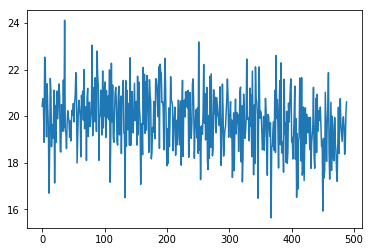

In [29]:
#tlosses = train()
plt.plot(tlosses)
plt.show()



In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os.path

data_file= '/Users/admin/Documents/Anuj/Coding/Warehouse/input.txt'

data = open(data_file, 'r').read()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print ('data has %d characters, %d unique.' % (data_size, vocab_size))

char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 2e-1
batch_size = 50
num_epochs = 500

FileNotFoundError: [Errno 2] No such file or directory: '/Users/admin/Documents/Anuj/Coding/Warehouse/input.txt'

In [31]:
# Convert an array of chars to array of vocab indices
def c2i(inp):
    return map(lambda c:char_to_ix[c], inp)

def i2c(inp):
    return map(lambda c:ix_to_char[c], inp)

# Generate data for an epoch, with batches of size batch_size.
def gen_epoch_data(raw_data, batch_size):
    data_len = len(raw_data)
    num_examples = (data_len - 1) // seq_length
    num_batches = num_examples // batch_size

    epoch_data = []
    for i in range(num_batches):
        batch = []
        idx = i * batch_size * seq_length
        for j in range(batch_size):
            inp = raw_data[idx + j*seq_length:idx + (j+1)*seq_length]
            target = raw_data[idx + 1+(j*seq_length):idx + 1+((j+1)*seq_length)]

            batch.append([c2i(inp), c2i(target)])
        epoch_data.append(batch)
    return epoch_data


In [32]:
epoch_data = gen_epoch_data(data, batch_size)
init_state = tf.zeros([hidden_size, 1])

# Input
x = tf.placeholder(tf.int32, shape=(seq_length), name="x")
y = tf.placeholder(tf.int32, shape=(seq_length), name="y")
state = tf.zeros([hidden_size, 1])

# One Hot representation of the input
x_oh = tf.one_hot(indices=x, depth=vocab_size)
y_oh = tf.one_hot(indices=y, depth=vocab_size)

rnn_inputs = tf.unstack(x_oh)
rnn_targets = tf.unstack(y_oh)


In [33]:
# Setup the weights and biases.
with tf.variable_scope('rnn_cell'):
    Wxh = tf.get_variable('Wxh', [hidden_size, vocab_size])
    Whh = tf.get_variable('Whh', [hidden_size, hidden_size])
    Why = tf.get_variable('Why', [vocab_size, hidden_size])
    bh = tf.get_variable('bh', [hidden_size, 1])
    by = tf.get_variable('by', [vocab_size, 1])

# Actual math behind computing the output and the next state of the RNN.
def rnn_cell(rnn_input, cur_state):
    with tf.variable_scope('rnn_cell', reuse=True):
        Wxh = tf.get_variable('Wxh', [hidden_size, vocab_size])
        Whh = tf.get_variable('Whh', [hidden_size, hidden_size])
        Why = tf.get_variable('Why', [vocab_size, hidden_size])
        bh = tf.get_variable('bh', [hidden_size, 1])
        by = tf.get_variable('by', [vocab_size, 1])
    inp = tf.expand_dims(rnn_input, 1)

    next_state = tf.tanh(tf.matmul(Wxh, inp) + tf.matmul(Whh, cur_state) + bh)
    y_hat = tf.matmul(Why, next_state) + by
    return y_hat, next_state

In [34]:
logits = []
for rnn_input in rnn_inputs:
    y_hat, state = rnn_cell(rnn_input, state)
    y_hat = tf.squeeze(y_hat)
    logits.append(y_hat)

losses = [tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=target) for logit, target in zip(logits, rnn_targets)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdadeltaOptimizer(learning_rate).minimize(total_loss)

num_samples = 25
sample_state = init_state
seed = tf.placeholder(tf.int32, [1], name='seed')
rnn_input = tf.one_hot(seed, vocab_size)
ixes = []

rnn_input = tf.squeeze(rnn_input)
y_hat, sample_state = rnn_cell(rnn_input, sample_state)
prob = tf.nn.softmax(tf.squeeze(y_hat))



In [35]:
def train():
    
    tlosses = []
    
    #save the model
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        if os.path.isfile("model.ckpt"):
            saver.restore(sess, "model.ckpt")
        else:
            sess.run(tf.global_variables_initializer())

        for epoch_idx in range(num_epochs):
            print ('--- Starting Epoch:', epoch_idx, '---')
            epoch_loss = 0
            epoch_state = np.zeros([hidden_size, 1])
            equals = 0.0
            for idx, batch in enumerate(epoch_data):
                training_loss = 0
                for example_idx, example in enumerate(batch):
                    x_i = example[0]
                    y_i = example[1]
                    x_i_val = np.array(list(x_i))
                    y_i_val = np.array(list(y_i))
                    
                    loss, tloss, _, logits_, rnn_targets_, epoch_state = \
                        sess.run([losses, total_loss, train_step, logits, \
                            rnn_targets, state], \
                                feed_dict={x:x_i_val, y:y_i_val, init_state:epoch_state}
                        )

                    logits_argmax = np.argmax(logits_, axis=1)
                    rnn_targets_argmax = np.argmax(rnn_targets_, axis=1)
                    equals += np.sum(logits_argmax == rnn_targets_argmax)

                    training_loss += tloss

                    if (example_idx % 100 == 0):
                        if list(example[0]) != []:
                            inp_seed = np.array([list(example[0])])
                        else:
                            inp_seed = np.array([1])

                        print ('\n')
                        print ('--- SAMPLE BEGIN ---')
                        num_chars = 100
                        ixes = []
                        sstate = np.zeros([hidden_size, 1])
                        for j in range(num_chars):
                            prob_r, sstate = sess.run([prob, sample_state], feed_dict={seed:inp_seed, init_state:sstate, x:x_i_val})
                            ix = np.random.choice(vocab_size, p=prob_r.ravel())
                            ixes.append(ix)
                            inp_seed = np.array([ix])

                        print (''.join(i2c(ixes)))
                        print ('--- SAMPLE END ---')

                training_loss /= len(batch)
                equals /= len(batch)
                print ('Epoch:', epoch_idx, 'Batch:', idx)
                print ('Average training loss in batch:', training_loss)
                print ('Average matching chars per batch:', equals)
                tlosses.append(training_loss)
            save_path = saver.save(sess, "model.ckpt")
            print("Model saved in file: %s" % save_path)
    return tlosses


In [36]:
tlosses = train()
plt.plot(tlosses)
plt.show()

--- Starting Epoch: 0 ---


--- SAMPLE BEGIN ---
4SgqO'aU,Pg"VXSe"qISTD`7I4
d5)w)Zx)ld,1cy):C1gW-fHgO1_!os*lWxx!PlccdutPW"IcjtjtXEq;;7"hXfOP9r)qOH"hq
--- SAMPLE END ---
Epoch: 0 Batch: 0
Average training loss in batch: 4.306205129623413
Average matching chars per batch: 1.4


--- SAMPLE BEGIN ---
lhG27Oq\ 29-PJx :ws1ubKA" arXoI
RCCFv?kR97!nXO5vT;epr n2el7pEAvQ!s9BMXQgMWkzGt0 9Vr(Nw?.O?'gt"5&\AeT
--- SAMPLE END ---
Epoch: 0 Batch: 1
Average training loss in batch: 3.9453311014175414
Average matching chars per batch: 3.208


--- SAMPLE BEGIN ---
x:G\
fTQ? u !IUe  n.p4n 6 d\dXCueVVgVd!dslZ0ekVEC1tU.ampVl
,E)mFQ;gW.  ThFkT!T9a* fu SeOUT
s3TV x7V 
--- SAMPLE END ---
Epoch: 0 Batch: 2
Average training loss in batch: 3.6412173748016357
Average matching chars per batch: 3.66416


--- SAMPLE BEGIN ---
GNj;ZFiuBz'EfouV4 ?eg bN r.kAnninJ,dpeGV P1 eens9wIPdsVgw k ghidEBh"sp Ih ,"ey0B d tFvt Vpde
e e Nw 
--- SAMPLE END ---
Epoch: 0 Batch: 3
Average training loss in batch: 3.6726701354980467
Average

Epoch: 0 Batch: 31
Average training loss in batch: 3.2041555213928223
Average matching chars per batch: 4.2008639932942655


--- SAMPLE BEGIN ---
 eeMgda goegsyt,sl;trarcftnuhiii ttoya,a
agt Pteeer  f ssir 1teHnigitrotltlGyd. eahhlssnn "bnrzo
fe 
--- SAMPLE END ---
Epoch: 0 Batch: 32
Average training loss in batch: 3.2304961824417116
Average matching chars per batch: 4.224017279865885


--- SAMPLE BEGIN ---
p
ivi". troh fo asey or
a eu mgfhrs oaeiorrmd feheud.ntah ayrgg,otktsolrre
rAld aaneih
 Wrona  i r'.
--- SAMPLE END ---
Epoch: 0 Batch: 33
Average training loss in batch: 3.1595081520080566
Average matching chars per batch: 4.084480345597317


--- SAMPLE BEGIN ---
CBeernte tt
u aaictd,aPlspw perlrsr ehsi.wH iao karitbeettwtraheil onrersekrFd esd neh tmuta bdxmwos
--- SAMPLE END ---
Epoch: 0 Batch: 34
Average training loss in batch: 3.276337447166443
Average matching chars per batch: 4.121689606911946


--- SAMPLE BEGIN ---
Fi ,aynhlntr earsona. alre rr t vsia  

ndae  rvorweTh deae 

Epoch: 0 Batch: 62
Average training loss in batch: 3.1124158668518067
Average matching chars per batch: 5.039015336055852


--- SAMPLE BEGIN ---
i yheI ieesitsahsl o ek"  asO"eilbr 
od!soqds mec faorw e svfsAaok tlslAeag,ofhehhe  Otcr s-aeolol n
--- SAMPLE END ---
Epoch: 0 Batch: 63
Average training loss in batch: 3.1654891395568847
Average matching chars per batch: 4.800780306721117


--- SAMPLE BEGIN ---
xv uullesbh d lttFo ees uem,Frnkdo ot esrw haE awrme wava. lus Y osl uvbtdpssiout thnts e Fs so'idi 
--- SAMPLE END ---
Epoch: 0 Batch: 64
Average training loss in batch: 3.164950098991394
Average matching chars per batch: 4.856015606134423


--- SAMPLE BEGIN ---
rtt lIn taonroinofvs baott.tdI sGeca loowe suohmv hitisilluciwiM oLhzir,lk

onhroe awin, s "d nilsuu
--- SAMPLE END ---
Epoch: 0 Batch: 65
Average training loss in batch: 3.0338065242767334
Average matching chars per batch: 4.997120312122688


--- SAMPLE BEGIN ---
; no t,dtl nns ccn  hoew-voaaIMtc,d uutlnwtssi  iTtouon tWerm

Epoch: 0 Batch: 93
Average training loss in batch: 2.918818483352661
Average matching chars per batch: 5.864021190256672


--- SAMPLE BEGIN ---
vi .hhw
i -ecd se eoig manr aomd olgt""urtcmimatid"f holacpfn h,o inrpyp iyew edeWaha nfrchnrruk
R n
--- SAMPLE END ---
Epoch: 0 Batch: 94
Average training loss in batch: 2.893707046508789
Average matching chars per batch: 5.337280423805133


--- SAMPLE BEGIN ---
TW
ont
aeslhae ehBr  no teeuud.nl ,ifR tyev
i'vweg atk ketm uolpec eada.wtentleh,
 herghyel-iz rfcri
--- SAMPLE END ---
Epoch: 0 Batch: 95
Average training loss in batch: 2.9410134077072145
Average matching chars per batch: 5.706745608476103


--- SAMPLE BEGIN ---
5i ao u. obed aee  an Psdn'l ireaDdhrtlrst.e indnn toudrn coergdog dddhuhsy p e a aee HtsrgHtmy tnan
--- SAMPLE END ---
Epoch: 0 Batch: 96
Average training loss in batch: 2.9343727016448975
Average matching chars per batch: 5.454134912169523


--- SAMPLE BEGIN ---
Urgeihflhu"  iesel sdr d s
etb Toi?eni  ta wss'eerf hYdl ynw
B

Epoch: 0 Batch: 124
Average training loss in batch: 2.9078054857254028
Average matching chars per batch: 6.006362444702229


--- SAMPLE BEGIN ---
Sb fad
hong ife ielsolt dii &as iochhsilos fhea ew mgs anr'othTad r
'ael rakaeeRp earetzpd,daL teip 
--- SAMPLE END ---
Epoch: 0 Batch: 125
Average training loss in batch: 2.935299792289734
Average matching chars per batch: 5.720127248894045


--- SAMPLE BEGIN ---
m iisd ntoh moetswlthe  onnkFwie  oaihedoh. rqwevs fo traret nov,sQHld? Mht,Pn
"iie eoorhiec,
a hls 
--- SAMPLE END ---
Epoch: 0 Batch: 126
Average training loss in batch: 2.8880029582977294
Average matching chars per batch: 6.0344025449778815


--- SAMPLE BEGIN ---
!w Wa
teenbo.
 tfeaac anieiI.,ntbn, kbnam lok th'abiwlr"flH a ating leod t, deh oond taomwnm wa slot
--- SAMPLE END ---
Epoch: 0 Batch: 127
Average training loss in batch: 2.835505876541138
Average matching chars per batch: 6.320688050899557


--- SAMPLE BEGIN ---
ta yvio  noiguQ iHkl woe tenCiwgces oannlw"k(a nsewy
slso

KeyboardInterrupt: 